In [67]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister# transpile, assemble, Aer, execute
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import math

# Quantum effects for Ludo Tokens

In [68]:
def bitstring_to_int_pos(bitstring):
    """Convert a bitstring to a positive integer."""
    return int(bitstring, 2)

def bitstring_to_int_neg(bitstring):
    """Convert a bitstring to a negative integer."""
    return (int(bitstring, 2))*-1


def token_circuit_initialization():
    dice_qc = QuantumCircuit(6, 6)  # Create a quantum circuit with 6 qubits and 6 classical bits
    #Apply series of gate to attenuate probability of '000' and '111'
    dice_qc.h(0)
    dice_qc.h(1)
    dice_qc.h(2)
    dice_qc.h(3)
    dice_qc.h(4)
    dice_qc.h(5)
    dice_qc.ccx(2, 1, 0)  # Apply Toffoli gate (CCNOT) to qubits 2,1,0
    dice_qc.ccx(5, 4, 3)  # Apply Toffoli gate (CCNOT) to qubits 5,4,3
    dice_qc.rz(math.pi/3, 2)  # Apply a small rotation to qubit 2
    dice_qc.rz(math.pi/3, 5)  # Apply a small rotation to qubit 2

    return dice_qc

def blockade_entanglement(qc1, qc2):
    """"Create a new quantum circuit with qc1.num_qubits + qc2.num_qubits qubits and qc1.num_clbits + qc2.num_clbits classical bits from 2 circuits.
    This is to simulate the entanglement between two tokens triggered when two tokens from a player form create a blockade. The two tokens can be from the same player or not.
        qc1 (QuantumCircuit): The first quantum circuit.
        qc2 (QuantumCircuit): The second quantum circuit.
    Returns:
        QuantumCircuit: A new quantum circuit that combines qc1 and qc2 with a CNOT gate to introduce entanglement between circuits.
    """""
    total_num_qubits = qc1.num_qubits + qc2.num_qubits
    total_num_clbits = qc1.num_clbits + qc2.num_clbits
    combined_qc = QuantumCircuit(total_num_qubits, total_num_clbits)
    # Add first circuit to qubits 0 and qc1.num_qubits

    combined_qc.compose(qc1, qubits=range(0, qc1.num_qubits), clbits=range(qc1.num_clbits), inplace=True)
    combined_qc.barrier()  # Add a barrier for clarity
    # Add second circuit to qubits qc1.num_qubits and qc1.num_qubits + qc2.num_qubits
    combined_qc.compose(qc2, qubits=range(qc1.num_qubits, qc1.num_qubits + qc2.num_qubits), clbits=range(qc1.num_clbits, qc1.num_clbits + qc2.num_clbits), inplace=True)
    # combined_qc.compose(qc2, clbits=[qc1.num_clbits, qc1.num_clbits + qc2.num_clbits], inplace=True)
    combined_qc.barrier()  # Add a barrier for clarity
    # Add a CNOT gate between the first qubit of qc1 and the first qubit of qc2 to introduce entanglement between the two circuits
    combined_qc.cx(0, qc1.num_qubits)
    return combined_qc

def measure_blockade_entanglement(qc):
    """Measure the entanglement between two circuits by measuring the first qubit of each circuit.
    Args:
        qc (QuantumCircuit): The quantum circuit with entanglement.
    Returns:
        QuantumCircuit: A new quantum circuit with measurements of the first qubit of each circuit.
    """
    for i in range(qc.num_qubits):
        qc.measure(i, i)

    # Run single shot measurement
    simulator = AerSimulator()
    job = simulator.run(qc, shots=1, memory=True)

    # Get the result
    result = job.result()
    memory = result.get_memory()  # Gets the single shot result

    nb_of_tokens = qc.num_qubits // 6

    measurment_per_token = [] # Stores the state for each token
    for token in range(0, nb_of_tokens, 6):
        measurment_per_token.append(memory[0][token:token + 6])  # Since each token has 6 qubits
    dice_results = []  # Stores the dice results for each token as tuples of (dice 1, dice 2)
    # Need to convert each dice into a number
    #for i in range(0, nb_of_tokens, 3):
    dice_results = (bitstring_to_int_pos(measurment_per_token[0][0:3]), bitstring_to_int_pos(measurment_per_token[0][4:6])) # Adds positive values of the dice
    return dice_results

def measure_blockade_anti_entanglement(qc):
    """Measure the entanglement between two circuits by measuring the first qubit of each circuit.
    Args:
        qc (QuantumCircuit): The quantum circuit with entanglement.
    Returns:
        QuantumCircuit: A new quantum circuit with measurements of the first qubit of each circuit.
    """
    for i in range(qc.num_qubits):
        qc.measure(i, i)

    # Run single shot measurement
    simulator = AerSimulator()
    job = simulator.run(qc, shots=1, memory=True)

    # Get the result
    result = job.result()
    memory = result.get_memory()  # Gets the single shot result

    nb_of_tokens = qc.num_qubits // 6

    measurment_per_token = [] # Stores the state for each token
    for token in range(0, nb_of_tokens, 6):
        measurment_per_token.append(memory[0][token:token + 6])  # Since each token has 6 qubits
    
    dice_results = []  # Stores the dice results for each token as tuples of (dice 1, dice 2)
    # Need to convert each dice into a number
    #for i in range(nb_of_tokens):
        #if i == nb_of_tokens - 1: # Last token is anti-entangled
    dice_results = (bitstring_to_int_neg(measurment_per_token[0][0:3]), bitstring_to_int_neg(measurment_per_token[0][4:6]))
        #else:
    dice_results = (bitstring_to_int_pos(measurment_per_token[0][0:3]), bitstring_to_int_pos(measurment_per_token[0][4:6])) # Adds positive values of the dice
    return dice_results

def probability_boost_110(qc):
    # Apply series of gate to boost probability of '110'
    amplification_gates_seq = QuantumCircuit(3, 3)  # Create a quantum circuit of 3 qubits and 3 classical bits with sequence of gate used to amplifying state '110' through Grover's algorithm. 

    # Apply Hadamard gate to all qubits to create superposition
    amplification_gates_seq.h([0, 1, 2])
    # Apply X gate to the target state '110'
    amplification_gates_seq.x(2)  # Apply X gate to qubit 2
    amplification_gates_seq.x(1)  # Apply X gate to qubit 1
    amplification_gates_seq.ccx(0, 1, 2)  # Toffoli gate
    amplification_gates_seq.z(2)  # Apply phase flip to qubit 2
    amplification_gates_seq.ccx(0, 1, 2)  # Uncompute
    amplification_gates_seq.x(0)  # Unflip qubit 0
    amplification_gates_seq.x(1)  # Unflip qubit 1

    # Step 3: Diffusion operator (amplification)
    amplification_gates_seq.h([0, 1, 2])
    amplification_gates_seq.x([0, 1, 2])
    amplification_gates_seq.h(2)
    amplification_gates_seq.ccx(0, 1, 2)
    amplification_gates_seq.h(2)
    amplification_gates_seq.x([0, 1, 2])
    amplification_gates_seq.h([0, 1, 2])

    nb_tokens = qc.num_qubits//6
    for i in range (0, 3*nb_tokens, 3):
        qc.compose(amplification_gates_seq, qubits=range(i, i + 3), clbits = range(i, i + 3),inplace=True)
    return qc

def probability_boost_001(qc):
    # Apply series of gate to increase probability of '001'
    amplification_gates_seq = QuantumCircuit(3, 3)  # Create a quantum circuit of 3 qubits and 3 classical bits with sequence of gate used to amplifying state '110' through Grover's algorithm. 

    # Apply Hadamard gate to all qubits to create superposition
    amplification_gates_seq.h([0, 1, 2])
    # Apply X gate to the target state '001'
    amplification_gates_seq.x(0)  # Apply X gate to qubit 0
    amplification_gates_seq.ccx(0, 1, 2)  # Toffoli gate
    amplification_gates_seq.z(2)  # Apply phase flip to qubit 2
    amplification_gates_seq.ccx(0, 1, 2)  # Uncompute
    amplification_gates_seq.x(0)  # Unflip qubit 0
    amplification_gates_seq.x(1)  # Unflip qubit 1

    # Step 3: Diffusion operator (amplification)
    amplification_gates_seq.h([0, 1, 2])
    amplification_gates_seq.x([0, 1, 2])
    amplification_gates_seq.h(2)
    amplification_gates_seq.ccx(0, 1, 2)
    amplification_gates_seq.h(2)
    amplification_gates_seq.x([0, 1, 2])
    amplification_gates_seq.h([0, 1, 2])

    nb_tokens = qc.num_qubits//6
    for i in range (0, 3*nb_tokens, 3):
        qc.compose(amplification_gates_seq, qubits=range(i, i + 3), clbits = range(i, i + 3),inplace=True)
    return qc

def state_teleportation(qc1, qc2):
    """Create a new quantum circuit with qc1.num_qubits + qc2.num_qubits qubits and qc1.num_clbits + qc2.num_clbits classical bits from 2 circuits.
    This is to simulate the teleportation of a state from one circuit to another.
        qc1 (QuantumCircuit): The first quantum circuit.
        qc2 (QuantumCircuit): The second quantum circuit.
    Returns:
        QuantumCircuit: A new quantum circuit that combines qc1 and qc2 with a CNOT gate to introduce entanglement between circuits.
    """
    qc_token_1 = QuantumRegister(6, 'qc_token_1')      # Q0–Q5 - State of token 1 to teleport
    q_entangled_A = QuantumRegister(6, 'q_A')      # Q6–Q11 (Alice's half)
    qc_token_2 = QuantumRegister(6, 'q_B')      # Q12–Q17 (Bob's half and receiver of the teleportation)
    # Classical registers
    # Classical registers to hold measurement results
    c_x = ClassicalRegister(6, 'c_x')              # Result of Hadamard+measure
    c_z = ClassicalRegister(6, 'c_z')              # Result of CNOT+measure

    # Create the quantum circuit
    qc = QuantumCircuit(qc_token_1, q_entangled_A, qc_token_2, c_x, c_z)

    # Creating Bell pair between qc_entangled_A and qc_token_2 (Alice and Bob)
    for i in range(6):
        qc.h(q_entangled_A[i])
        qc.cx(q_entangled_A[i], qc_token_2[i])

    # Teleporting individually every qubit :
    for i in range(6):
        # Bell-state measurement
        qc.cx(qc_token_1[i], q_entangled_A[i]) # CNOT gate
        qc.h(qc_token_1[i])

        # Measurement of qubits 
        qc.measure(qc_token_1[i], c_x[i])
        qc.measure(q_entangled_A[i], c_z[i])

    # Correcting the state of qc_token_2 based on the measurement results
    for i in range(6):
        qc.x(qc_token_2[i]).c_if(c_x, 1 << i)  # Apply X gate if c_x[i] is 1
        qc.z(qc_token_2[i]).c_if(c_z, 1 << i)  # Apply Z gate if c_z[i] is 1
    
    teleported_state = QuantumCircuit(6, 6)  # Create a quantum circuit for the teleported state
    teleported_state.compose(qc[12:17], inplace=True)  # Compose the teleportation circuit into the teleported state circuit
    return teleported_state

# TESTING FUNCTIONS 

# Initinializing token quantum circuit

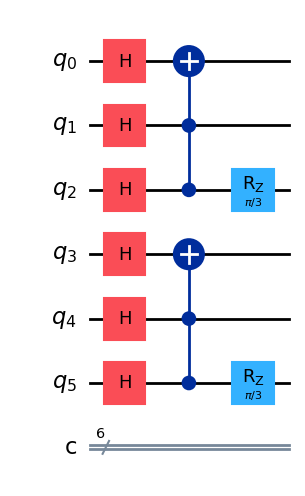

In [69]:
token_1 = token_circuit_initialization()
token_1.draw('mpl')  # Draw the circuit

# Simulate blockade entaglement

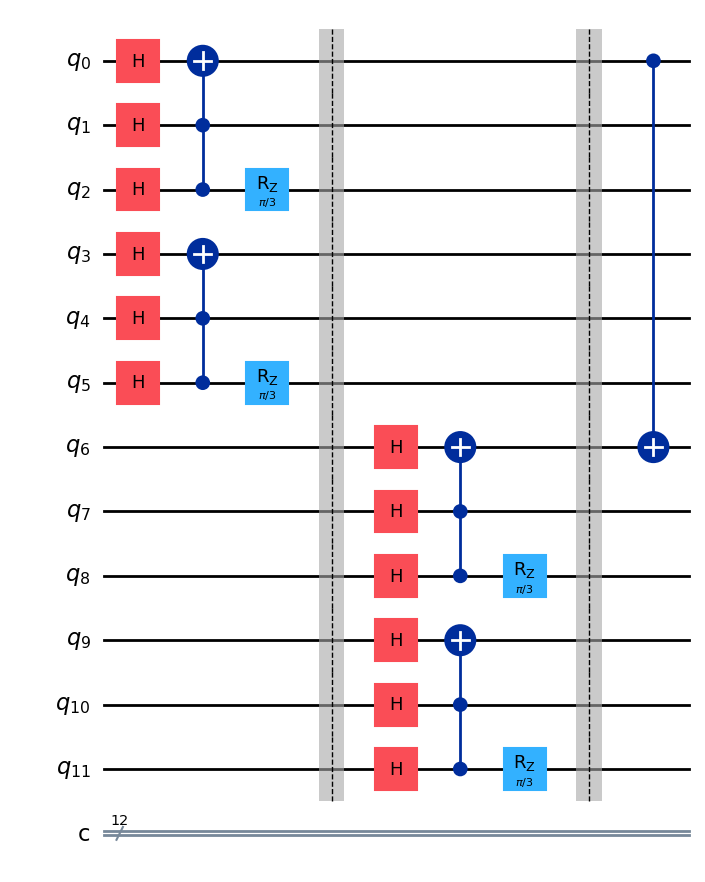

In [70]:
token_1 = token_circuit_initialization()
token_2 = token_circuit_initialization()
entangled_circuit = blockade_entanglement(token_1, token_2)
entangled_circuit.draw('mpl')  # Draw the entangled circuit


In [71]:
# Measure the entanglement 
print("Measurement results of the entangled circuit:")
print(measure_blockade_entanglement(entangled_circuit))
# Measure the anti-entanglement
print("Measurement results of the anti-entangled circuit:")
print(measure_blockade_anti_entanglement(entangled_circuit))

Measurement results of the entangled circuit:
(1, 0)
Measurement results of the anti-entangled circuit:
(6, 3)


# Simulate probability boosting for 6

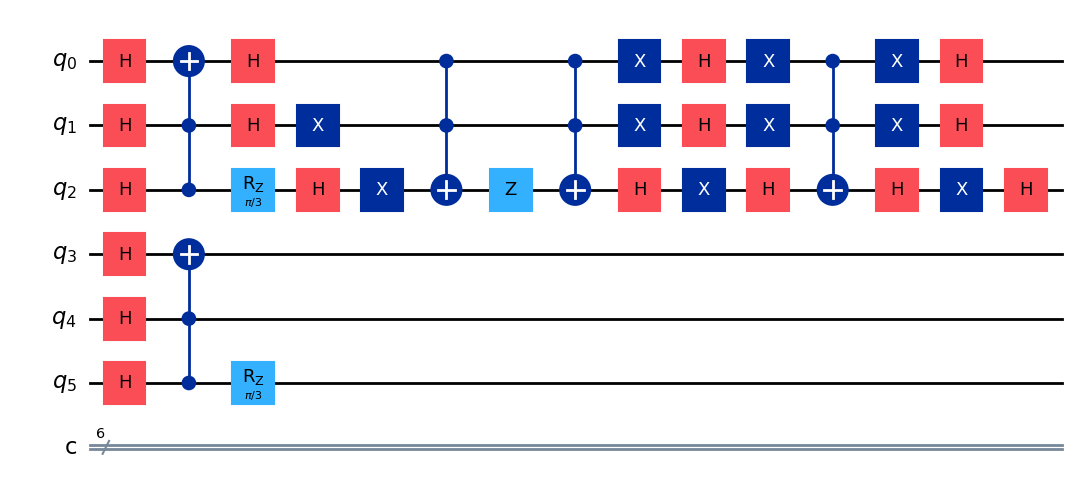

In [72]:
token_1 = token_circuit_initialization()
token_boosted_110 = probability_boost_110(token_1)
token_boosted_110.draw('mpl')  # Draw the boosted circuit

# Simulate probability boosting for 1

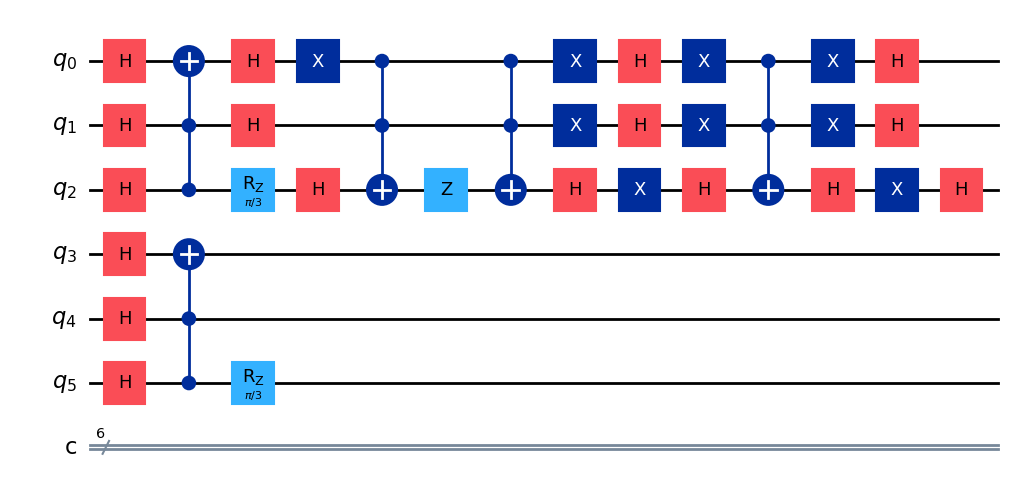

In [73]:
token_1 = token_circuit_initialization()
token_boosted_001 = probability_boost_001(token_1)
token_boosted_001.draw('mpl')  # Draw the boosted circuit